<a href="https://colab.research.google.com/github/pruthamodak/Image_Segmentation_UNet_EfficientNet/blob/main/ImageSegmentation_UNet_EncEffficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 32.7 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=ec36093c3cdc24295f76b7d6a9873ba51ec63020086c15ac3a6e0110b803be24
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=a6aac6c1826007c26973ebd51f795d98d348e79576ccf2254252b6014c0a58c9
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-9o1et01h
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-9o1et01h
   

In [ ]:
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 66.7 MB 19 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 8.56 MiB/s, done.
Resolving deltas: 100% (3/3), done.


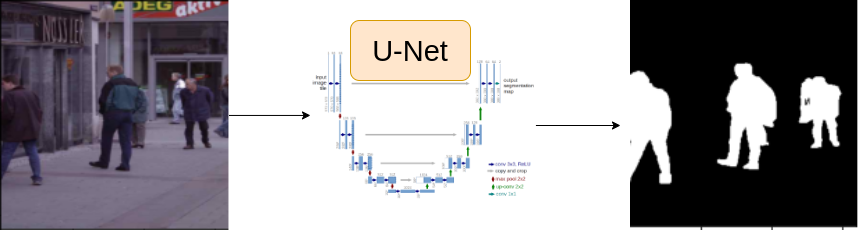

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE ='cuda'

EPOCHS = 50
LR = 0.001
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[6]

img_path = row.images
mask_path = row.masks

img = cv2.imread(img_path) # cv2 reads image in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converted to RGB

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


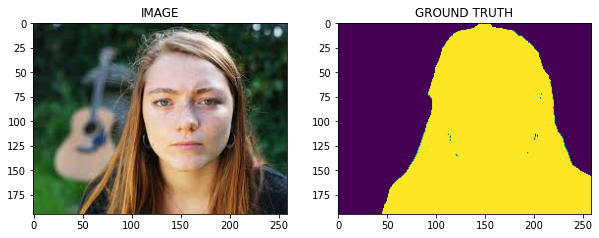

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(img)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)
#ax2.imshow(mask,cmap = 'gray')


In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def train_augmentation():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE), # Resize Image (width=height=IMAGE_SIZE)
      A.HorizontalFlip(p=0.5), # Horizontal Flip Image Probability 50%
      A.VerticalFlip(p=0.5)
  ])

In [ ]:
def valid_augmentation():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE) # Resize Image (width=height=IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class Segmentation_Dataset (Dataset):
  
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):

    return len(self.df)

  def __getitem__(self, index):
    
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # Add one extra dimension "Channel" in mask 
    mask = np.expand_dims(mask, axis=-1) # (h,w,c=1) for grayscale image

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # Returns data in dictionary format, Key : Image, Value : Mask
      image = data['image']
      mask = data['mask']

    # Pytorch uses c,h,w convention : (h,w,c) -> (c,h,w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    
    # Convert to tensor : Range between 0 to 1 : Scale image divide by 255.0
    image = torch.Tensor(image) / 255.0
    mask = torch.Tensor(mask) / 255.0

    return image,mask

In [ ]:
train_set = Segmentation_Dataset(train_df, train_augmentation())
valid_set = Segmentation_Dataset(valid_df, valid_augmentation())

In [ ]:
print(f"Size of Trainset : {len(train_set)}")
print(f"Size of Validset : {len(valid_set)}")

Size of Trainset : 232
Size of Validset : 58


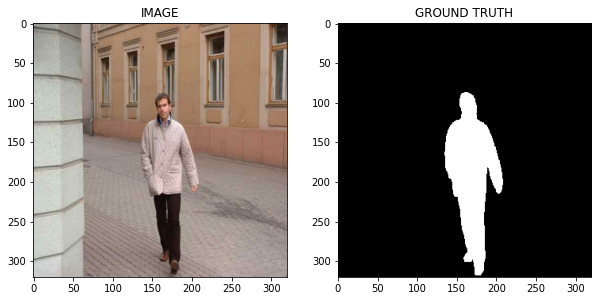

In [ ]:
idx = 14
image, mask = train_set[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True) # shuffle batches at each epoch
valid_dataloader = DataLoader(valid_set, batch_size = BATCH_SIZE)

In [ ]:
print(f"Total number of batches in Train DataLoader : {len(train_dataloader)}")
print(f"Total number of batches in Valid DataLoader : {len(valid_dataloader)}")

Total number of batches in Train DataLoader : 15
Total number of batches in Valid DataLoader : 4


In [ ]:
for image, mask in train_dataloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")
# (Batch size, no. of channels, height, width)

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
# Segmentation models based on Auto-Encoders
# Using UNet here

from torch import nn
import segmentation_models_pytorch as smp

In [ ]:
class Segmentation_Model(nn.Module):

  def __init__(self):
    
    super(Segmentation_Model, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, # RGB : 3 channels
        classes = 1, # BInary Segmentation
        activation = None 
    )

  def forward(self, images, masks = None):

    logits = self.arc(images) # Output : Logits => Raw outputs without any activation

    if masks != None: # For train valid
      loss_1 = smp.losses.DiceLoss('binary')(logits, masks) # Binary Problem
      loss_2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss_1 + loss_2

    return logits # For Inference

In [ ]:
model = Segmentation_Model()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Segmentation_Model(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, ep

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_model(data_loader, model, optimizer):
  
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_model(data_loader, model):
  
  model.eval() # No dropout function
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  
  train_loss = train_model(train_dataloader, model, optimizer)
  valid_loss = eval_model(valid_dataloader, model)
  
  if(valid_loss < best_valid_loss):
    torch.save(model.state_dict(),'best_model.pt')
    print("MODEL SAVED")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} == Train Loss : {train_loss}, Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


MODEL SAVED
Epoch : 1 == Train Loss : 0.9590601404507955, Valid Loss : 0.46725713461637497


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


MODEL SAVED
Epoch : 2 == Train Loss : 0.4311960995197296, Valid Loss : 0.32293393462896347


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 3 == Train Loss : 0.28810224334398904, Valid Loss : 0.3571135327219963


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


MODEL SAVED
Epoch : 4 == Train Loss : 0.25049883822600044, Valid Loss : 0.23927073553204536


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


MODEL SAVED
Epoch : 5 == Train Loss : 0.212308469414711, Valid Loss : 0.20276645570993423


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch : 6 == Train Loss : 0.2244331250588099, Valid Loss : 0.24470936506986618


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 7 == Train Loss : 0.1773671676715215, Valid Loss : 0.23007674887776375


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


MODEL SAVED
Epoch : 8 == Train Loss : 0.1498176912466685, Valid Loss : 0.19157464057207108


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 9 == Train Loss : 0.13888529886802037, Valid Loss : 0.19404248148202896


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


MODEL SAVED
Epoch : 10 == Train Loss : 0.1474258581797282, Valid Loss : 0.17371875420212746


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch : 11 == Train Loss : 0.14638432015975317, Valid Loss : 0.20117998123168945


100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


MODEL SAVED
Epoch : 12 == Train Loss : 0.1154414047797521, Valid Loss : 0.1513802595436573


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 13 == Train Loss : 0.12487157185872395, Valid Loss : 0.16377874091267586


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epoch : 14 == Train Loss : 0.11903613905111948, Valid Loss : 0.16292888671159744


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 15 == Train Loss : 0.09782753735780716, Valid Loss : 0.15919415280222893


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


MODEL SAVED
Epoch : 16 == Train Loss : 0.09720611721277236, Valid Loss : 0.14618661254644394


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 17 == Train Loss : 0.1004808008670807, Valid Loss : 0.15331944823265076


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epoch : 18 == Train Loss : 0.11253496358791987, Valid Loss : 0.15910140797495842


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 19 == Train Loss : 0.09133499463399251, Valid Loss : 0.18502140417695045


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 20 == Train Loss : 0.08449980119864146, Valid Loss : 0.1700415164232254


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 21 == Train Loss : 0.1132986178000768, Valid Loss : 0.1738213263452053


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


MODEL SAVED
Epoch : 22 == Train Loss : 0.09186687916517258, Valid Loss : 0.1416576001793146


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch : 23 == Train Loss : 0.07961006611585617, Valid Loss : 0.14333305694162846


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 24 == Train Loss : 0.07337562392155329, Valid Loss : 0.14796462655067444


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


MODEL SAVED
Epoch : 25 == Train Loss : 0.07081475084026655, Valid Loss : 0.13822313025593758


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 26 == Train Loss : 0.06603212679425875, Valid Loss : 0.14598266035318375


100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Epoch : 27 == Train Loss : 0.06292810241381327, Valid Loss : 0.1575259119272232


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 28 == Train Loss : 0.06645910218358039, Valid Loss : 0.16249787248671055


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch : 29 == Train Loss : 0.06436753074328104, Valid Loss : 0.1614282839000225


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch : 30 == Train Loss : 0.06330062548319498, Valid Loss : 0.1629885546863079


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


MODEL SAVED
Epoch : 31 == Train Loss : 0.0602206548055013, Valid Loss : 0.13263248652219772


100%|██████████| 4/4 [00:01<00:00,  2.79it/s]


Epoch : 32 == Train Loss : 0.058886579672495526, Valid Loss : 0.14485415630042553


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epoch : 33 == Train Loss : 0.07663199255863826, Valid Loss : 0.16433219611644745


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 34 == Train Loss : 0.11718771855036418, Valid Loss : 0.18589448928833008


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 35 == Train Loss : 0.10088823934396109, Valid Loss : 0.2007308453321457


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 36 == Train Loss : 0.08513180961211522, Valid Loss : 0.21864719316363335


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch : 37 == Train Loss : 0.0740665559967359, Valid Loss : 0.2196984738111496


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epoch : 38 == Train Loss : 0.06584423085053762, Valid Loss : 0.18700006790459156


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 39 == Train Loss : 0.061166900147994356, Valid Loss : 0.17145796120166779


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 40 == Train Loss : 0.06439962138732275, Valid Loss : 0.16081997752189636


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch : 41 == Train Loss : 0.05849078719814618, Valid Loss : 0.17148443683981895


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch : 42 == Train Loss : 0.05944491202632586, Valid Loss : 0.17079532332718372


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch : 43 == Train Loss : 0.05821722522377968, Valid Loss : 0.19502223283052444


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch : 44 == Train Loss : 0.05237428272763888, Valid Loss : 0.21243259496986866


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 45 == Train Loss : 0.05101272811492284, Valid Loss : 0.21401779912412167


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epoch : 46 == Train Loss : 0.055114384492238364, Valid Loss : 0.19813254103064537


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch : 47 == Train Loss : 0.06081146995226542, Valid Loss : 0.21444004029035568


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch : 48 == Train Loss : 0.05827936852971713, Valid Loss : 0.20032357424497604


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch : 49 == Train Loss : 0.05900160819292068, Valid Loss : 0.27551113441586494


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

Epoch : 50 == Train Loss : 0.05813462262352308, Valid Loss : 0.20613930746912956


# Task 9 : Inference

In [ ]:
idx = 13

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = valid_set[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) -> (b=1,c,h,w)
pred_mask = torch.sigmoid(logits_mask) # Binary Segmentation : Activation -> Sigmoid
pred_mask = (pred_mask > 0.5)*1.0

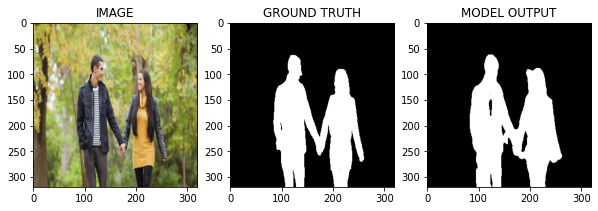

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))